In [ ]:
'''File for visualisation of data augumentations'''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import sys
sys.path.append("../")

from datasets.FreiHAND import FreiHAND, FreiHAND_albu
from albumentations.pytorch.transforms import ToTensorV2


from config import *

import albumentations as A
import cv2
from PIL import Image

CROP_HEIGHT = 200
RANDOM_CROP_SIZE = 180

/caa/Homes01/wmucha/venvs/hands_keypoints/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [3]:
config = {
    "data_dir": "/data/wmucha/datasets/FreiHAND",
    "model_path": "/caa/Homes01/wmucha/repos/applied_deep_learning/applied_dl/saved_models/fulldata_aug2_53",
    "test_batch_size": 32,
    "device": 3
}

In [25]:
albumetations = A.Compose(
        [
            # A.Resize(MODEL_IMG_SIZE,MODEL_IMG_SIZE),
            A.SafeRotate(always_apply=False, p=0.5, limit=(-20, 20), interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None),
            # A.CenterCrop(always_apply=False, p=1.0, height=150, width=150),
            A.HorizontalFlip(always_apply=False, p=0.5),
            A.VerticalFlip(always_apply=False, p=0.5),
            A.RandomResizedCrop(always_apply=True, p=0.5, height=MODEL_IMG_SIZE, width=MODEL_IMG_SIZE, scale=(0.3, 1.0), ratio=(1, 1), interpolation=0),
            A.MotionBlur(always_apply=False, p=0.2, blur_limit=(3, 7), allow_shifted=True),
            A.RandomGridShuffle(always_apply=False, p=0.2, grid=(2, 2)),
            A.Downscale(always_apply=False, p=0.2, scale_min=0.9, scale_max=0.99),
            # A.Normalize(mean = TRAIN_DATASET_MEANS,std = TRAIN_DATASET_STDS),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible = False)
)

albu_dataset = FreiHAND_albu(config=config, set_type="train", albumetations = albumetations)

albu_dataloader = DataLoader(
    albu_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)


/caa/Homes01/wmucha/venvs/hands_keypoints/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


Number of train samples: 130240


In [17]:
img_transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    # transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS),
                ]
            )

heatmap_transform = transforms.Compose(
                [
          
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                  
                ]
            )

test_dataset = FreiHAND(config=config, set_type="train", img_transform= img_transform, heatmap_transform = heatmap_transform)
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)




Number of train samples: 130240


In [18]:
img_transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    # transforms.RandomRotation(degrees=(0, 30)),
                    # transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    # transforms.RandomHorizontalFlip(p=1),
                    # transforms.RandomVerticalFlip(p=1),
                    RandomNoise(),
                    transforms.GaussianBlur(3),
                    # transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS),
                ]
            )

heatmap_transform = transforms.Compose(
                [
          
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomVerticalFlip(p=1),
                  
                ]
            )

test_datasetrot = FreiHAND(config=config, set_type="train", img_transform= img_transform )
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

Number of train samples: 130240


In [19]:
def cv_to_pil(cv_image):
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv_image)
    return pil_image

In [20]:
def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
#     print(heatmaps.shape)
#     if heatmaps.shape == (21,128,128):
#          batch_size = 1
    batch_size = heatmaps.shape[0]
    
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints

In [21]:
def show_data(dataset, n_samples=1):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    # ids = [2305]
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image"]
        transform = transforms.ToPILImage()
        image = transform(image)
        # print(image)
        # print(type(image))
        # image = np.moveaxis(image, 0, -1)
       
        # image = cv_to_pil(image)
        
        heatmaps = sample["heatmaps"]
        # print(heatmaps.shape)
        heatmaps.resize(1,21,MODEL_IMG_SIZE,MODEL_IMG_SIZE)
        # print(heatmaps.shape)
        keypoints = heatmaps_to_coordinates(np.array(heatmaps))
       
        # keypoints = sample["keypoints"]
        keypoints = keypoints[0] #* MODEL_IMG_SIZE
        # print(keypoints)


        plt.subplot(n_rows, n_cols, i)
        # plt.imshow(  image.permute(1, 2, 0)  )
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()

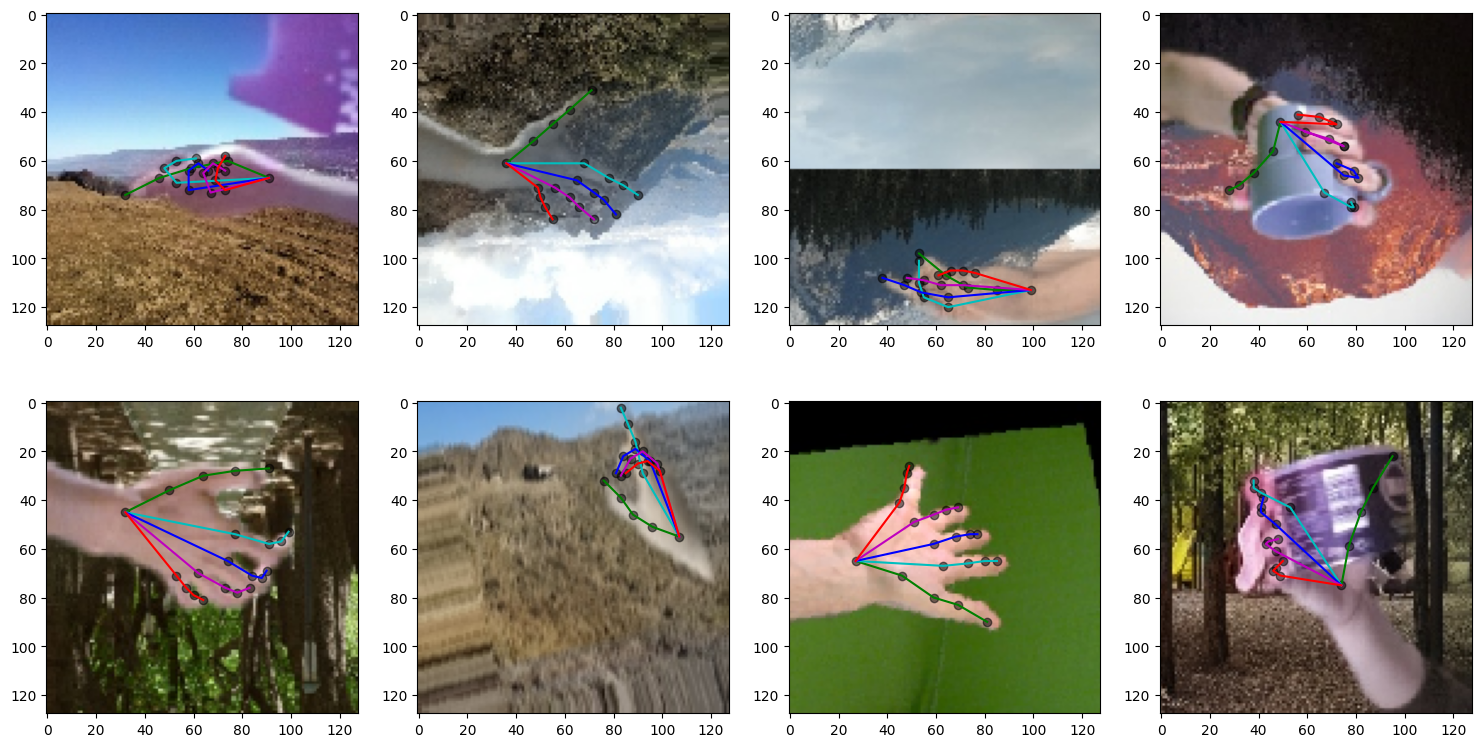

In [26]:
show_data(albu_dataset, n_samples=8)